# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 16.11.2024

Мягкий дедлайн: 28.11.2024

Жесткий дедлайн: 02.12.2024

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [1]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pl.Config().set_tbl_rows(100)
pl.Config().set_tbl_cols(100)

polars.config.Config

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [3]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: При стратегии uniform случайный классификатор равномерно генерирует вероятность принадлежности объекта к классу 1 (и, соответственно, вероятность принадлежности к классу 0 равна 1-p). На этапе предсказания методом predict_proba классификатор ещё не принимает решение о конкретном классе (0 или 1). Он лишь выдаёт вероятности. Если бы мы использовали метод predict, модель бы вернула конкретные классы, основанные на пороге (по умолчанию 0.5).

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [4]:
from sklearn.metrics import average_precision_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000


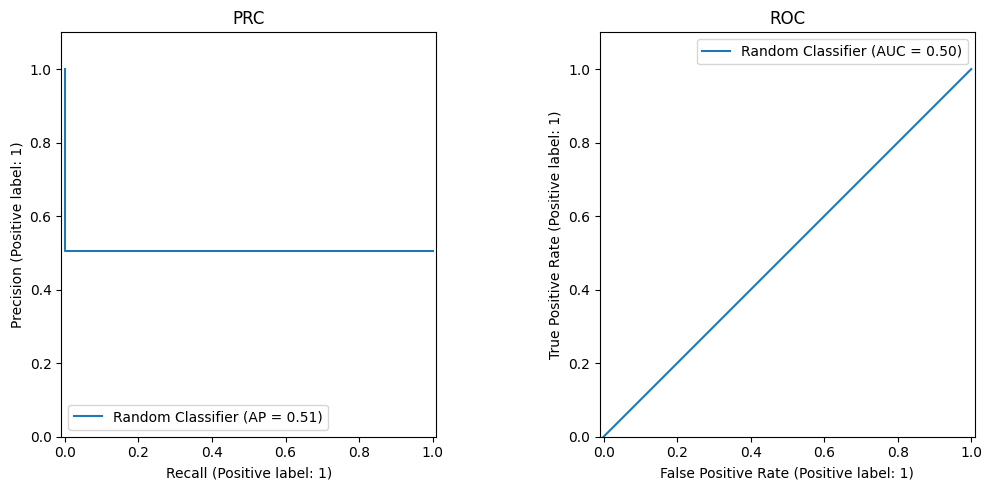

In [5]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    print('AUC-PR: %.4f' % average_precision_score(y_true, y_pred))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.4f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [6]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(
    columns=['auc_pr', 'roc_auc_score', 'reg_const']
)
precision, recall, _ = precision_recall_curve(y_test, y_random)
# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      average_precision_score(y_test, y_random),
      roc_auc_score(y_test, y_random),
      0,
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


Лучшее значение C: 10
Linear SVM metrics
AUC-PR: 0.8299
AUC-ROC: 0.8476


,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.0
Linear SVM,0.829914,0.847647,10.0


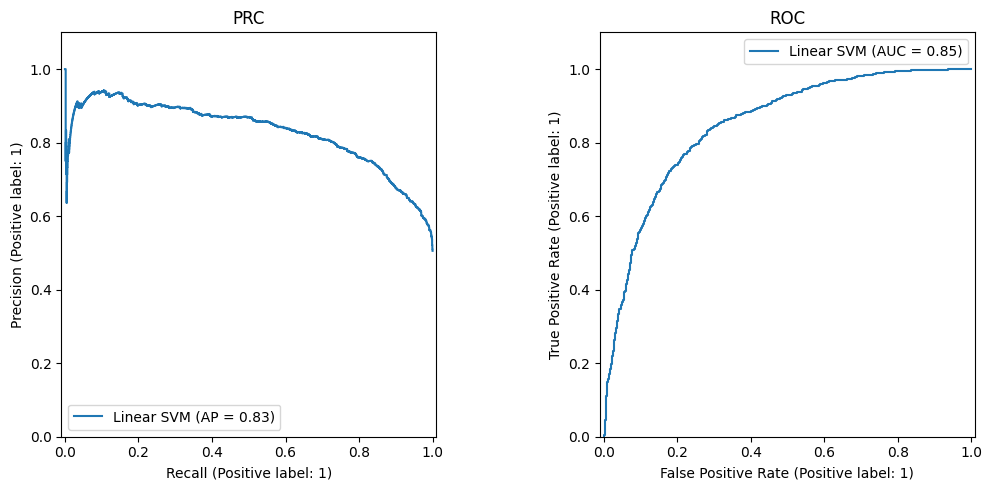

In [7]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score, roc_auc_score

param_grid = {'estimator__C': [0.01, 0.1, 1, 10, 100]}
base_estimator = LinearSVC(random_state=42, max_iter=10000)
model = CalibratedClassifierCV(estimator=base_estimator, cv=5)

grid_search = GridSearchCV(
    model,
    param_grid,
    scoring='average_precision',
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_C_SVM = grid_search.best_params_['estimator__C']
print('Лучшее значение C:', grid_search.best_params_['estimator__C'])

y_pred = best_model.predict_proba(X_test)[:, 1]

depict_pr_roc(y_test, y_pred, 'Linear SVM')

df_metrics.loc['Linear SVM'] = [
    average_precision_score(y_test, y_pred),
    roc_auc_score(y_test, y_pred),
    grid_search.best_params_['estimator__C']
]

df_metrics

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR

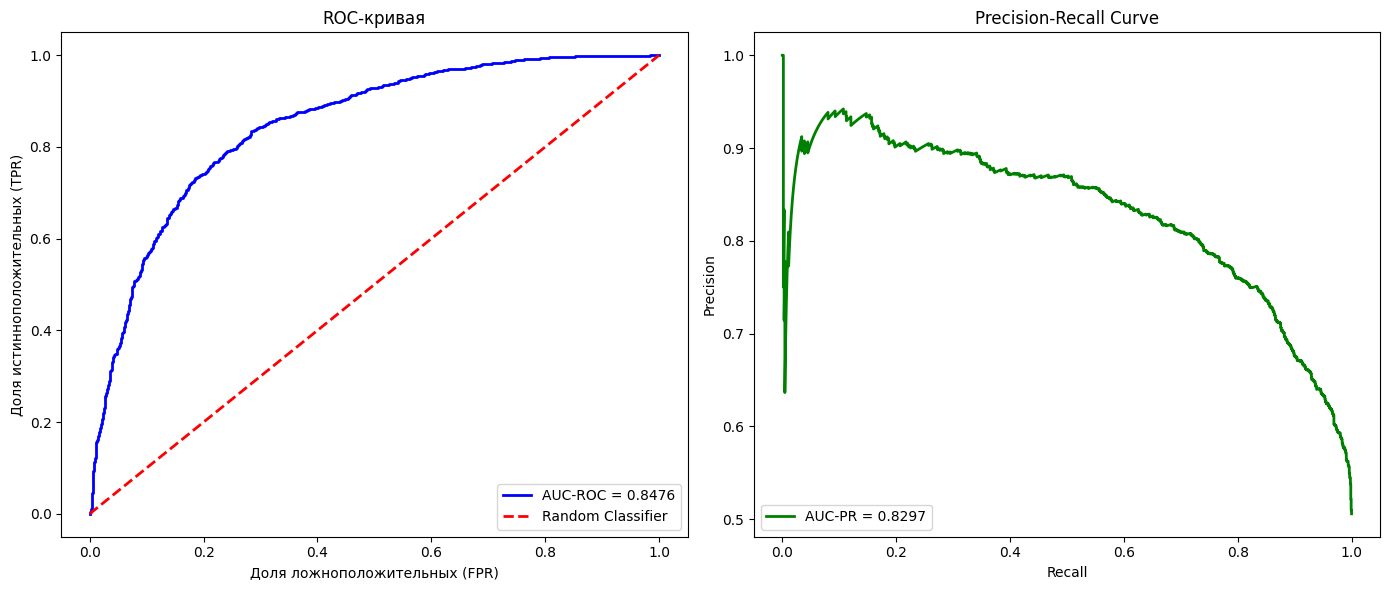

In [8]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].plot(fpr, tpr, color='blue', lw=2, label=f'AUC-ROC = {roc_auc:.4f}')
ax[0].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier')
ax[0].set_xlabel('Доля ложноположительных (FPR)')
ax[0].set_ylabel('Доля истинноположительных (TPR)')
ax[0].set_title('ROC-кривая')
ax[0].legend(loc='lower right')

ax[1].plot(recall, precision, color='green', lw=2, label=f'AUC-PR = {pr_auc:.4f}')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall Curve')
ax[1].legend(loc='lower left')

plt.tight_layout()
plt.show()

In [9]:
print(f'AUC-ROC: {roc_auc:.4f}')
print(f'AUC-PR: {pr_auc:.4f}')

df_metrics.loc['Linear SVM'] = [
    average_precision_score(y_test, y_pred),
    roc_auc_score(y_test, y_pred),
    grid_search.best_params_['estimator__C']
]

df_metrics

AUC-ROC: 0.8476
AUC-PR: 0.8297


,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.0
Linear SVM,0.829914,0.847647,10.0


Проанализируйте, как себя ведут обе кривые:
- Что происходит при увеличении порога? Как бы вы это проинтерпретировали?
- Монотонные ли кривые? Как вы это объясните?

При увеличении порога модель становится более "осторожной" в определении положительных классов. Это значит, что меньше объектов классифицируется как положительные. В результате снижается количество ложных срабатываний, но вместе с этим уменьшается и количество правильно предсказанных положительных объектов. Поэтому, модель старается снизить риск ошибочных положительных предсказаний, но это может уменьшить полноту.

При повышении порога полнота падает, так как модель упускает некоторые истинно положительные примеры. Precision наоборот может либо увеличиваться, либо уменьшаться. Если оставшиеся положительные предсказания точны, то Precision растет. Если же ложноположительных много, то Precision падает.

ROC-кривая всегда монотонная. Она показывает, как изменяются истинно положительные и ложноположительные доли при разных порогах, и рост FPR никогда не приводит к снижению TPR. Это связано с тем, что ROC отражает общий баланс между правильными и ошибочными классификациями, которые упорядочены по убыванию вероятности.

PR-кривая может быть немонотонной. Это связано с тем, что точность и полнота зависят от соотношения между истинными и ложноположительными предсказаниями. На некоторых этапах добавление ложноположительных предсказаний может временно ухудшить точность, что и приводит к неровностям на графике.

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [10]:
random_auc_roc = roc_auc_score(y_test, y_random)
random_auc_pr = average_precision_score(y_test, y_random)

svm_auc_roc = roc_auc_score(y_test, y_pred)
svm_auc_pr = average_precision_score(y_test, y_pred)

print(f"Случайный классификатор - AUC-ROC: {random_auc_roc:.4f}, AUC-PR: {random_auc_pr:.4f}")
print(f"Модель (Linear SVM) - AUC-ROC: {svm_auc_roc:.4f}, AUC-PR: {svm_auc_pr:.4f}")

Случайный классификатор - AUC-ROC: 0.5000, AUC-PR: 0.5057
Модель (Linear SVM) - AUC-ROC: 0.8476, AUC-PR: 0.8299


__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



Лучшее значение C для Logistic Regression: 0.01
Logistic Regression metrics
AUC-PR: 0.8300
AUC-ROC: 0.8475


,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.00
Linear SVM,0.829914,0.847647,10.00
Logistic Regression,0.830047,0.847505,0.01


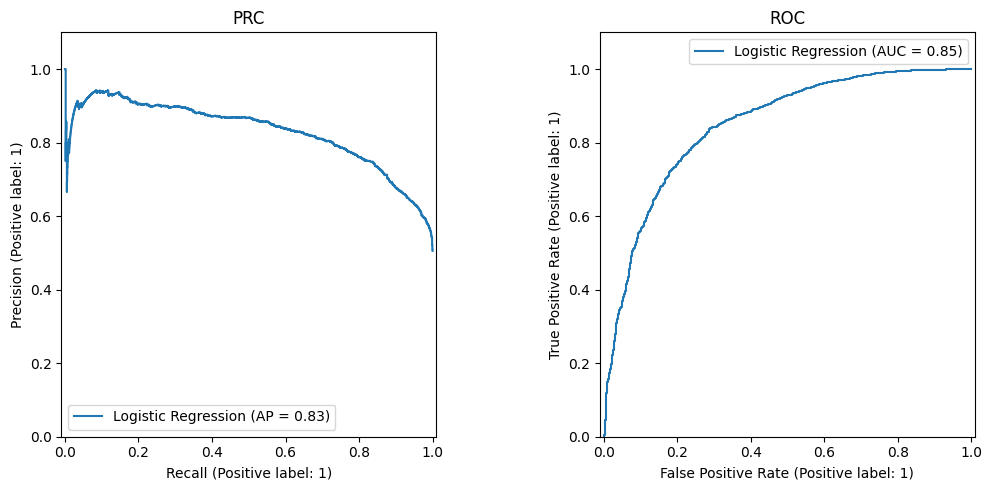

In [11]:
from sklearn.linear_model import LogisticRegression

param_grid_lr = {'estimator__C': [0.01, 0.1, 1, 10, 100]}

base_estimator_lr = LogisticRegression(
    penalty='l2',
    solver='lbfgs',
    max_iter=10000,
    random_state=42
)

model_lr = CalibratedClassifierCV(estimator=base_estimator_lr, cv=5)

grid_search_lr = GridSearchCV(
    model_lr,
    param_grid_lr,
    scoring='average_precision',
    cv=5,
    n_jobs=-1
)

grid_search_lr.fit(X_train, y_train)
best_model_lr = grid_search_lr.best_estimator_
best_C_lr = grid_search_lr.best_params_['estimator__C']
print('Лучшее значение C для Logistic Regression:', grid_search_lr.best_params_['estimator__C'])

y_pred_lr = best_model_lr.predict_proba(X_test)[:, 1]
depict_pr_roc(y_test, y_pred_lr, 'Logistic Regression')

df_metrics.loc['Logistic Regression'] = [
    average_precision_score(y_test, y_pred_lr),
    roc_auc_score(y_test, y_pred_lr),
    grid_search_lr.best_params_['estimator__C']
]

df_metrics

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

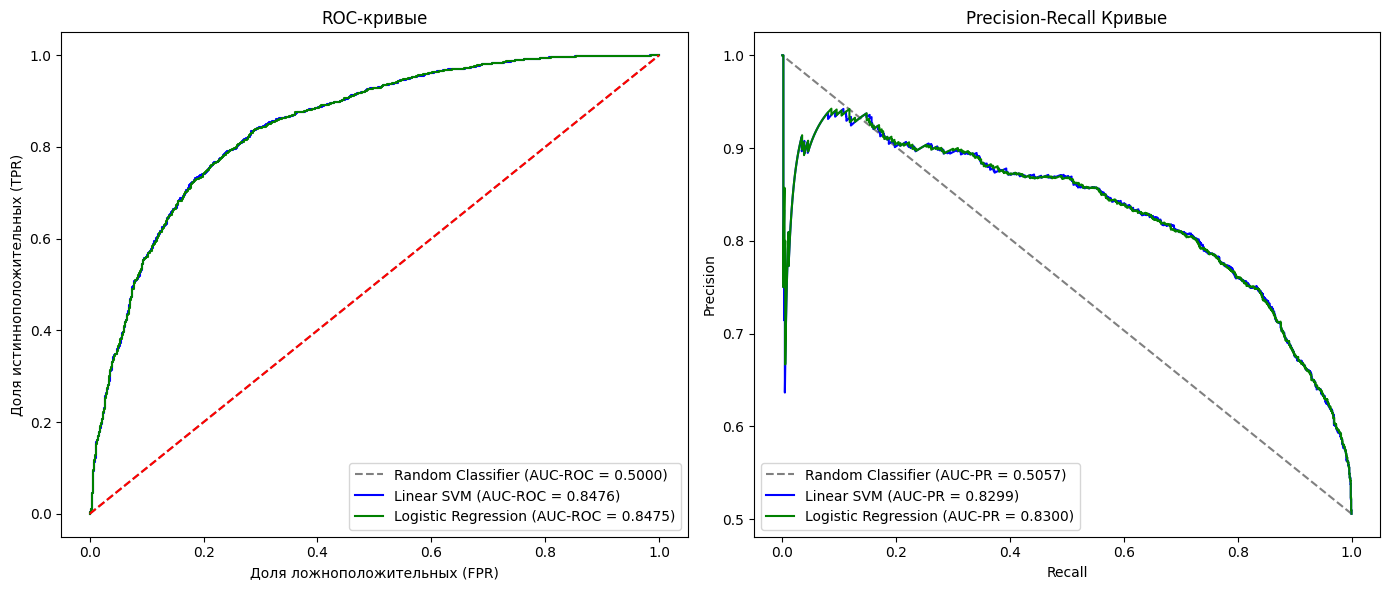

In [12]:
y_pred_random = y_random
y_pred_svm = y_pred
y_pred_lr = y_pred_lr

fpr_random, tpr_random, _ = roc_curve(y_test, y_pred_random)
roc_auc_random = roc_auc_score(y_test, y_pred_random)

precision_random, recall_random, _ = precision_recall_curve(y_test, y_pred_random)
pr_auc_random = average_precision_score(y_test, y_pred_random)

fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_svm)
roc_auc_svm = roc_auc_score(y_test, y_pred_svm)

precision_svm, recall_svm, _ = precision_recall_curve(y_test, y_pred_svm)
pr_auc_svm = average_precision_score(y_test, y_pred_svm)

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_pred_lr)

precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_lr)
pr_auc_lr = average_precision_score(y_test, y_pred_lr)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr_random, tpr_random, linestyle='--', label=f'Random Classifier (AUC-ROC = {roc_auc_random:.4f})', color='grey')
plt.plot(fpr_svm, tpr_svm, label=f'Linear SVM (AUC-ROC = {roc_auc_svm:.4f})', color='blue')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC-ROC = {roc_auc_lr:.4f})', color='green')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Доля ложноположительных (FPR)')
plt.ylabel('Доля истинноположительных (TPR)')
plt.title('ROC-кривые')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall_random, precision_random, linestyle='--', label=f'Random Classifier (AUC-PR = {pr_auc_random:.4f})', color='grey')
plt.plot(recall_svm, precision_svm, label=f'Linear SVM (AUC-PR = {pr_auc_svm:.4f})', color='blue')
plt.plot(recall_lr, precision_lr, label=f'Logistic Regression (AUC-PR = {pr_auc_lr:.4f})', color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Кривые')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:**

- Random Classifier	0.5000	0.5057
- Linear SVM	0.8476	0.8299
- Logistic Regression	0.8475	0.8300

AUC-ROC (площадь под ROC-кривой): Оба классификатора показали очень схожие результаты (~0.847). Это говорит о том, что обе модели одинаково хорошо различают положительные и отрицательные классы.

AUC-PR (площадь под Precision-Recall кривой): Logistic Regression немного лучше (0.8300 против 0.8299 у SVM). Это преимущество связано с тем, что логистическая регрессия изначально работает с вероятностями.

Результаты моделей отличаются, потому что они работают по-разному. Logistic Regression изначально оптимизирует вероятности и сразу возвращает точные предсказания, поэтому её результаты хорошо интерпретируемы. SVM, в свою очередь, фокусируется на разделении классов, создавая максимально широкую границу между ними. Однако для получения вероятностей SVM требует дополнительной калибровки, что может немного снизить точность. Logistic Regression лучше справляется с простыми линейными данными, тогда как SVM подходит для более сложных случаев, особенно если в данных есть выбросы или их трудно разделить.

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы. Ниже есть шаблоны, можете воспользоваться ими, либо написать своё

In [13]:
X, y = make_classification(
    n_samples=10000, n_features=2, n_informative=2, n_redundant=0, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
from sklearn.svm import SVC

model = SVC(kernel='linear', C = best_C_SVM)
model.fit(X_train, y_train)

SVC(C=10, kernel='linear')

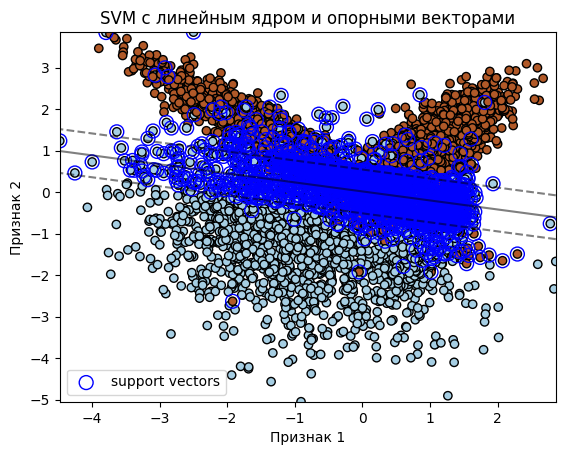

In [15]:
def plot_svm_2D(X, y, model,  plot_support=True):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(XX.shape)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    # Отрисовали выборку
    plt.scatter(
        X[:, 0],
        X[:, 1],
        c=y,
        cmap=plt.cm.Paired,
        edgecolors='k'
    )

    # Отрисовали опорные векторы
    if plot_support:
        plt.scatter(
            model.support_vectors_[:, 0],
            model.support_vectors_[:, 1],
            label='support vectors',
            s=100,
            linewidth=1,
            edgecolor="blue",
            facecolors='none'
        )

    plt.legend()
    plt.title('SVM с линейным ядром и опорными векторами')
    plt.xlabel('Признак 1')
    plt.ylabel('Признак 2')
    plt.show()

plot_svm_2D(X_train, y_train, model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** На графике опорными векторами выделены те объекты, которые находятся ближе всего к разделяющей линии (гиперплоскости) или пересекают её. Эти точки обведены синими кружками. Они играют ключевую роль в определении положения разделяющей прямой, так как задают ширину зазора (маржи) между классами. Без этих объектов разделяющая гиперплоскость могла бы сместиться, так как остальные точки, находящиеся дальше от границы, не оказывают влияния на обучение модели SVM.

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [16]:
from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression(random_state=42, C = best_C_lr)
logreg_model.fit(X, y)

LogisticRegression(C=0.01, random_state=42)

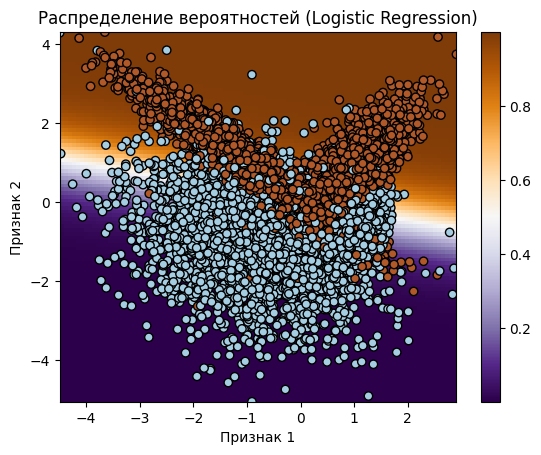

In [17]:
def plot_logreg_2D(X, y, model):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 1]
    Z = Z.reshape((xx.shape[0], -1)).T

    image = plt.imshow(
        Z,
        interpolation='nearest',
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect='auto',
        origin='lower',
        cmap=plt.cm.PuOr_r
    )

    #Отрисовали выборку
    plt.scatter(
        X[:, 0],
        X[:, 1],
        c=y,
        cmap=plt.cm.Paired,
        edgecolors='k'
    )

    plt.colorbar(image)
    plt.title('Распределение вероятностей (Logistic Regression)')
    plt.xlabel('Признак 1')
    plt.ylabel('Признак 2')
    plt.show()

plot_logreg_2D(X, y, logreg_model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** На графике такая область, визуализирована как белая полоса, разделяющая области разных цветов. Это происходит потому, что в этой зоне модель логистической регрессии присваивает объектам вероятность, близкую к 0.5, что означает одинаковую вероятность принадлежности к обоим классам. Теоретически, эта область соответствует разделяющей гиперплоскости модели, где значение линейной комбинации признаков равно нулю. Именно здесь сигмоидная функция вероятности принимает значение 0.5, что указывает на максимальную неопределённость модели.

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [18]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [19]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

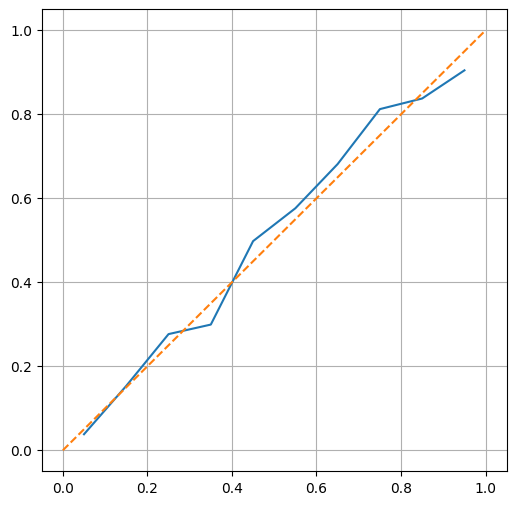

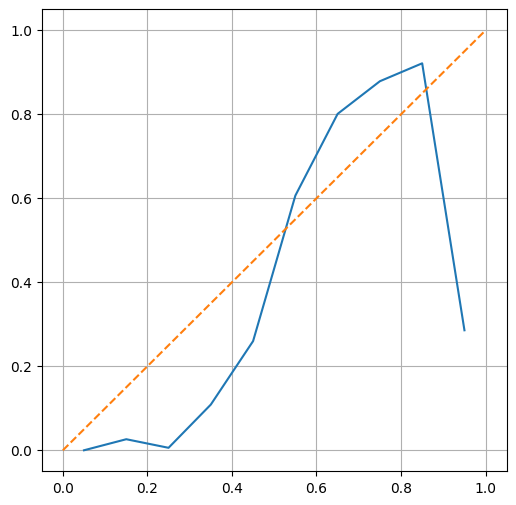

In [20]:
logreg_model = LogisticRegression(random_state=42, max_iter=10000, C = best_C_SVM)
logreg_model.fit(X_train, y_train)
logreg_preds = logreg_model.predict_proba(X_test)[:, 1]

svm_model = SVC(kernel='linear', probability=True, random_state=42, C = best_C_lr)
svm_model.fit(X_train, y_train)

svm_preds = svm_model.decision_function(X_test)
svm_preds = (svm_preds - svm_preds.min()) / (svm_preds.max() - svm_preds.min())

plot_calibration_curve(y_test, logreg_preds)
plt.plot([0,1], [0,1], '--')
plt.show()

plot_calibration_curve(y_test, svm_preds)
plt.plot([0,1], [0,1], '--')
plt.show()

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии? Подумайте, как это следует из вида кривой

**Ответ:** Логистическая регрессия:

Кривая достаточно близка к идеальной (пунктирной линии). Это говорит о том, что предсказанные вероятности логистической регрессии хорошо отражают реальные вероятности. Модель откалибрована корректно.
SVM:

Кривая для SVM заметно отклоняется от идеальной, особенно на высоких и низких вероятностях. Это означает, что предсказанные вероятности модели SVM плохо согласуются с реальными вероятностями. Модель не откалибрована должным образом, что ожидаемо, так как SVM не оптимизирован для выдачи точных вероятностей без дополнительной калибровки

Из формальных способов в этом убедиться есть знакомый вам LogLoss, который напрямую оценивает вероятности,
$$\text{LogLoss} = -\frac{1}{N}\sum_{i} \sum_{k \in {0. 1}}\log p_k[y_i = k]$$
а так же BrierScore, который подсчитывает отклонение между получившейся вероятностью и реальным значением таргета.
$$\text{BrierScore} = \frac{1}{N}\sum_{i} (p_i - y_i)^2$$
Посмотрите на них тоже и сделайте вывод

In [21]:
from sklearn.metrics import log_loss, brier_score_loss

logloss_logreg = log_loss(y_test, logreg_preds)
brier_logreg = brier_score_loss(y_test, logreg_preds)

logloss_svm = log_loss(y_test, svm_preds)
brier_svm = brier_score_loss(y_test, svm_preds)

print("Logistic Regression:")
print(f"LogLoss: {logloss_logreg:.4f}")
print(f"Brier Score: {brier_logreg:.4f}\n")

print("SVM:")
print(f"LogLoss: {logloss_svm:.4f}")
print(f"Brier Score: {brier_svm:.4f}")

Logistic Regression:
LogLoss: 0.4859
Brier Score: 0.1586

SVM:
LogLoss: 0.5559
Brier Score: 0.1847


Логистическая регрессия:

LogLoss: 0.4859 — меньшее значение LogLoss указывает на более точные вероятностные предсказания.

Brier Score: 0.1586 — указывает на лучшее соответствие предсказанных вероятностей реальным значениям.

SVM:

LogLoss: 0.5559 — большее значение LogLoss указывает на менее точные вероятностные предсказания.

Brier Score: 0.1847 — большее значение Brier Score подтверждает, что предсказания SVM откалиброваны хуже, чем у логистической регрессии.

Изучите распределение ответов классификаторов при помощи гистограмм

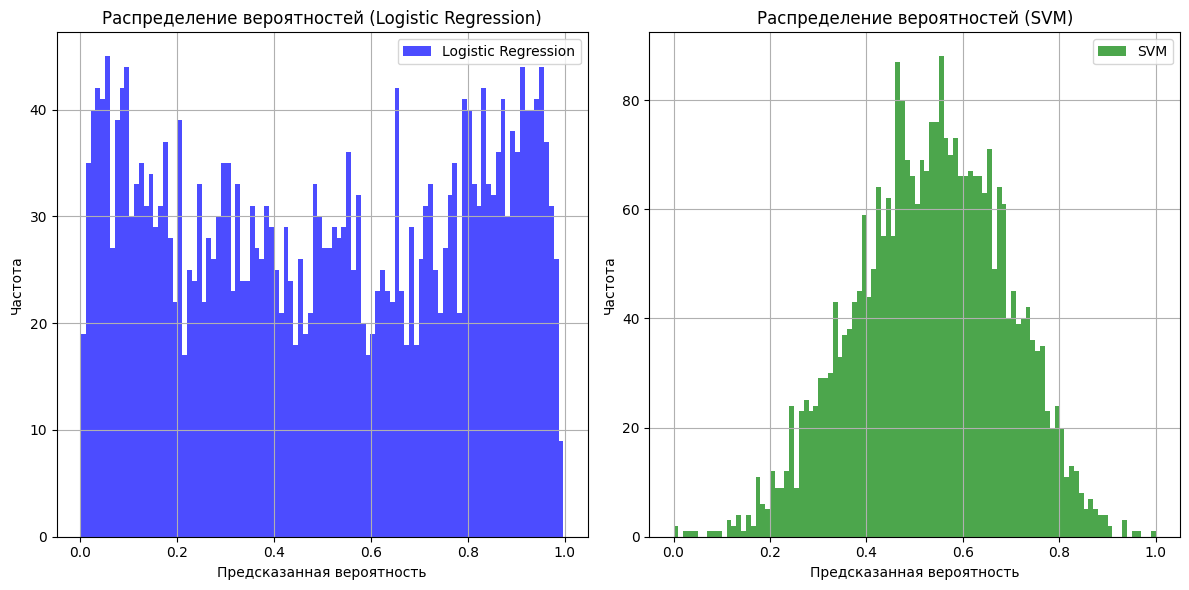

In [22]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(logreg_preds, bins=100, color='blue', alpha=0.7, label='Logistic Regression')
plt.title('Распределение вероятностей (Logistic Regression)')
plt.xlabel('Предсказанная вероятность')
plt.ylabel('Частота')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(svm_preds, bins=100, color='green', alpha=0.7, label='SVM')
plt.title('Распределение вероятностей (SVM)')
plt.xlabel('Предсказанная вероятность')
plt.ylabel('Частота')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** Распределение вероятностей у логистической регрессии более равномерное по всему диапазону от 0 до 1, потому что она изначально настроена на предсказание хорошо откалиброванных вероятностей. У SVM же вероятности больше сосредоточены вокруг 0.5, так как модель не рассчитана на выдачу точных вероятностей, а делает это через дополнительное преобразование, которое сжимает значения. Поэтому вероятности логистической регрессии лучше отражают уверенность модели.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

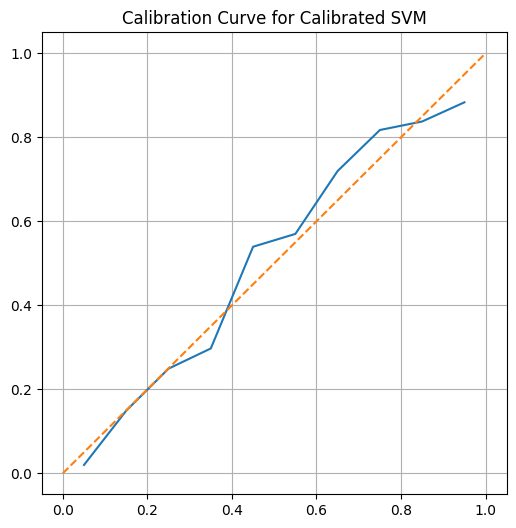

Calibrated SVM:
LogLoss: 0.4873
Brier Score: 0.1582


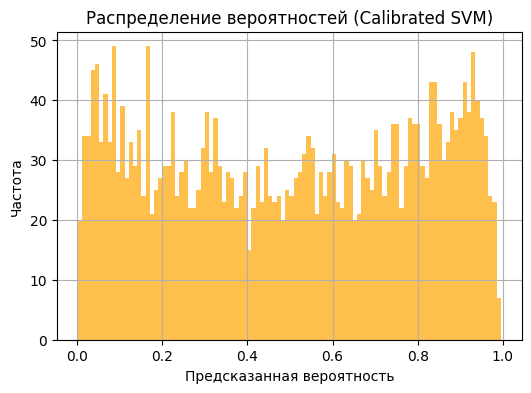

In [23]:
svm_model = SVC(kernel='linear', random_state=42, C=best_C_lr)

calibrated_svm = CalibratedClassifierCV(svm_model, cv=5, method='sigmoid')
calibrated_svm.fit(X_train, y_train)

svm_calibrated_preds = calibrated_svm.predict_proba(X_test)[:, 1]

plot_calibration_curve(y_test, svm_calibrated_preds)
plt.plot([0,1], [0,1], '--')
plt.title('Calibration Curve for Calibrated SVM')
plt.show()

logloss_svm_calibrated = log_loss(y_test, svm_calibrated_preds)
brier_svm_calibrated = brier_score_loss(y_test, svm_calibrated_preds)

print("Calibrated SVM:")
print(f"LogLoss: {logloss_svm_calibrated:.4f}")
print(f"Brier Score: {brier_svm_calibrated:.4f}")

plt.figure(figsize=(6, 4))
plt.hist(svm_calibrated_preds, bins=100, color='orange', alpha=0.7)
plt.title('Распределение вероятностей (Calibrated SVM)')
plt.xlabel('Предсказанная вероятность')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

**Вопрос:** Улучшились ли калибровочная кривая и качество калибровки?

**Ответ:** После калибровки калибровочная кривая SVM стала ближе к идеальной диагонали, что говорит об улучшении соответствия предсказанных вероятностей реальным. Распределение вероятностей стало более равномерным, охватывая весь диапазон от 0 до 1, вместо сосредоточения вокруг 0.5. Метрики LogLoss и Brier Score также улучшились, подтверждая, что калибровка сделала вероятности более точными. Теперь модель лучше оценивает вероятность принадлежности к положительному классу.

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [24]:
# your code here

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

*(бесценный шаг)*

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [25]:
import kagglehub

path = kagglehub.dataset_download("heeraldedhia/bike-buyers") +  "/bike_buyers.csv"

100%|██████████| 22.2k/22.2k [00:00<00:00, 17.7MB/s]

Extracting files...


In [26]:
# Прочитаем датасет
df = pd.read_csv('bike_buyers.csv')

# Заменим пропуски категориальных переменных
categorical_columns = df.select_dtypes(include=['object']).columns
df[categorical_columns] = df[categorical_columns].fillna('undefined')

# Отделим X и y
y = df['Purchased Bike'].map({'Yes': 1, 'No': 0})
X = df.drop('Purchased Bike', axis=1)

# Разделим на категориальные признаки и числовые
X_numerical = X.select_dtypes(include=['int64', 'float64'])
X_categorical = X.select_dtypes(include=['object'])

В начале поработаем только с категориальными признаками

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [28]:
from sklearn.preprocessing import OrdinalEncoder
import time

ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

start_time = time.time()

X_train_encoded = ordinal_encoder.fit_transform(X_train)
X_test_encoded = ordinal_encoder.transform(X_test)

logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_encoded, y_train)

end_time = time.time()
training_time = end_time - start_time
print(f"Время обучения модели с кодированием: {training_time:.4f} секунд")

y_pred_proba = logreg.predict_proba(X_test_encoded)[:, 1]

auc_pr = average_precision_score(y_test, y_pred_proba)
print(f"AUC-PR на тестовой выборке: {auc_pr:.4f}")

Время обучения модели с кодированием: 0.0125 секунд
AUC-PR на тестовой выборке: 0.5887


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [29]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

start_time = time.time()

X_train_encoded = onehot_encoder.fit_transform(X_train)
X_test_encoded = onehot_encoder.transform(X_test)

logreg = LogisticRegression(max_iter=1000, random_state=42)

logreg.fit(X_train_encoded, y_train)

end_time = time.time()
training_time = end_time - start_time
print(f"Время обучения модели с кодированием: {training_time:.4f} секунд")

y_pred_proba = logreg.predict_proba(X_test_encoded)[:, 1]

auc_pr = average_precision_score(y_test, y_pred_proba)
print(f"AUC-PR на тестовой выборке: {auc_pr:.4f}")

Время обучения модели с кодированием: 0.0230 секунд
AUC-PR на тестовой выборке: 0.6663


Модель стала лучше различать классы после применения One-Hot Encoding AUC-PR увеличился с 0.5887 до 0.6663. Время работы тоже увеличилось.

Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [30]:
start_time = time.time()

X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

global_mean = y_train.mean()

for col in X_train.columns:
    category_mean = y_train.groupby(X_train[col]).mean()
    X_train_encoded[col] = X_train[col].map(category_mean)
    X_test_encoded[col] = X_test[col].map(category_mean).fillna(global_mean)

logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_encoded, y_train)

end_time = time.time()
training_time = end_time - start_time
print(f"Время обучения модели с кодированием: {training_time:.4f} секунд")

y_pred_proba = logreg.predict_proba(X_test_encoded)[:, 1]
auc_pr = average_precision_score(y_test, y_pred_proba)
print(f"AUC-PR на тестовой выборке: {auc_pr:.4f}")

Время обучения модели с кодированием: 0.0348 секунд
AUC-PR на тестовой выборке: 0.6575


Качество модели немного ухудшилось относительно One-Hot Encoding кодирования, однако время обучения значительно уменишьлось и стало сравнимо с методом OrdinalEncoder, что говорит о том что это наиболее оптимальный метод кодирования при большом количчестве категорий.

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [31]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features):
        self.categorical_features = categorical_features
        self.target_means = {}
        self.global_mean = None

    def fit(self, X, y):
        self.global_mean = y.mean()
        self.target_means = {}

        for col in self.categorical_features:
            self.target_means[col] = y.groupby(X[col]).mean()

        return self

    def transform(self, X):
        X_transformed = X.copy()

        for col in self.categorical_features:
            X_transformed[col] = X[col].map(self.target_means[col]).fillna(self.global_mean)

        return X_transformed

In [32]:
start_time = time.time()
encoder = MeanTargetEncoder(categorical_features=X_categorical.columns)
encoder.fit(X_train, y_train)

X_train_encoded = encoder.transform(X_train)
X_test_encoded = encoder.transform(X_test)

logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_encoded, y_train)
end_time = time.time()

y_pred_proba = logreg.predict_proba(X_test_encoded)[:, 1]
auc_pr = average_precision_score(y_test, y_pred_proba)

print(f"Время обучения модели с кодированием: {end_time - start_time:.4f} секунд")
print(f"AUC-PR на тестовой выборке: {auc_pr:.4f}")

Время обучения модели с кодированием: 0.0338 секунд
AUC-PR на тестовой выборке: 0.6575


Качество и скорость сопостовимы с предыдущей реализацией.

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [33]:
def mean_target_encoding_with_noise(X_train, y_train, X_test, noise_level):
    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()

    global_mean = y_train.mean()

    for col in X_train.columns:
        category_mean = y_train.groupby(X_train[col]).mean()
        noise = np.random.randn(len(category_mean)) * noise_level
        category_mean_noisy = category_mean + noise
        X_train_encoded[col] = X_train[col].map(category_mean_noisy).fillna(global_mean)
        X_test_encoded[col] = X_test[col].map(category_mean_noisy).fillna(global_mean)

    return X_train_encoded, X_test_encoded

noise_level = 0.005

start_time = time.time()
X_train_encoded, X_test_encoded = mean_target_encoding_with_noise(X_train, y_train, X_test, noise_level)

logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_encoded, y_train)
end_time = time.time()
y_pred_proba = logreg.predict_proba(X_test_encoded)[:, 1]
auc_pr = average_precision_score(y_test, y_pred_proba)

print(f"Время обучения модели с кодированием: {end_time - start_time:.4f} секунд")
print(f"AUC-PR на тестовой выборке: {auc_pr:.4f}")

Время обучения модели с кодированием: 0.0263 секунд
AUC-PR на тестовой выборке: 0.6619


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** Добавление шума лишь немного увеличилось с 0.6575 до 0.6608. Это свидетельствует о том, что модель стала лучше обобщаться на новых данных, так как шум снижает вероятность переобучения на признаки, содержащие утечку целевой переменной. Mean-target encoding создает признаки, которые напрямую зависят от целевой переменной. Это может привести к утечке информации, где модель обучается на данных, которые уже содержат ответы.
Шум уменьшает точность предсказаний для конкретных категорий, создавая некоторую неопределенность, которая имитирует реальную ситуацию, где данные содержат шум и нет идеально предсказуемых категорий.

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [34]:
# your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times \text{global_mean}}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $\text{global_mean}$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [35]:
from sklearn.base import BaseEstimator, TransformerMixin

class SmoothedMeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features, C=10):
        self.categorical_features = categorical_features
        self.C = C
        self.global_mean = None
        self.target_means = {}

    def fit(self, X, y):
        self.global_mean = y.mean()
        self.target_means = {}

        for col in self.categorical_features:
            stats = y.groupby(X[col]).agg(['sum', 'count'])
            sums = stats['sum']
            counts = stats['count']
            smoothed_means = (sums + self.C * self.global_mean) / (counts + self.C)

            self.target_means[col] = smoothed_means

        return self

    def transform(self, X):
        X_transformed = X.copy()

        for col in self.categorical_features:
            X_transformed[col] = X[col].map(self.target_means[col]).fillna(self.global_mean)

        return X_transformed

In [36]:
C_values = [0.1, 1, 5, 10, 20, 50, 100, 500, 1000, 5000, 10000]
results = []

for C in C_values:
    start_time = time.time()
    encoder = SmoothedMeanTargetEncoder(categorical_features=X_categorical.columns, C=C)
    encoder.fit(X_train, y_train)

    X_train_encoded = encoder.transform(X_train)
    X_test_encoded = encoder.transform(X_test)

    logreg = LogisticRegression(max_iter=1000, random_state=42)
    logreg.fit(X_train_encoded, y_train)
    end_time = time.time()

    y_pred_proba = logreg.predict_proba(X_test_encoded)[:, 1]
    auc_pr = average_precision_score(y_test, y_pred_proba)
    training_time = end_time - start_time

    print(f"C = {C}, AUC-PR: {auc_pr:.4f}, Время обучения: {training_time:.4f} секунд")

    results.append({'C': C, 'AUC-PR': auc_pr, 'Training time': training_time})


C = 0.1, AUC-PR: 0.6565, Время обучения: 0.0492 секунд
C = 1, AUC-PR: 0.6619, Время обучения: 0.0336 секунд
C = 5, AUC-PR: 0.6706, Время обучения: 0.0377 секунд
C = 10, AUC-PR: 0.6713, Время обучения: 0.0341 секунд
C = 20, AUC-PR: 0.6694, Время обучения: 0.0383 секунд
C = 50, AUC-PR: 0.6648, Время обучения: 0.0354 секунд
C = 100, AUC-PR: 0.6562, Время обучения: 0.0345 секунд
C = 500, AUC-PR: 0.6109, Время обучения: 0.0328 секунд
C = 1000, AUC-PR: 0.6070, Время обучения: 0.0310 секунд
C = 5000, AUC-PR: 0.5840, Время обучения: 0.0281 секунд
C = 10000, AUC-PR: 0.5802, Время обучения: 0.0244 секунд


Как мы видим наилучшие результаты показывает С = 10

In [37]:
optimal_C = 10
start_time = time.time()
encoder = SmoothedMeanTargetEncoder(categorical_features=X_categorical.columns, C=optimal_C)
encoder.fit(X_train, y_train)

X_train_encoded = encoder.transform(X_train)
X_test_encoded = encoder.transform(X_test)

logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_encoded, y_train)
end_time = time.time()

y_pred_proba = logreg.predict_proba(X_test_encoded)[:, 1]
auc_pr = average_precision_score(y_test, y_pred_proba)
training_time = end_time - start_time

print(f"Оптимальное C = {optimal_C}, AUC-PR: {auc_pr:.4f}, Время обучения: {training_time:.4f} секунд")

Оптимальное C = 10, AUC-PR: 0.6713, Время обучения: 0.0439 секунд


Как видим мы добились качества лучше чем при One-Hot-Encoding.

#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к счётчикам (тем, которые дали наибольший прирост качества).


Проверьте их на наличие выбросов и заполните пропуски средним или медианой, подумайте, что лучше в условиях наших данных



In [38]:
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

X_train_numerical = X_train_full.select_dtypes(include=['int64', 'float64'])
X_train_categorical = X_train_full.select_dtypes(include=['object'])

X_test_numerical = X_test_full.select_dtypes(include=['int64', 'float64'])
X_test_categorical = X_test_full.select_dtypes(include=['object'])

print("Пропущенные значения в числовых признаках (тренировочный набор):")
print(X_train_numerical.isnull().sum())

print("\nПропущенные значения в числовых признаках (тестовый набор):")
print(X_test_numerical.isnull().sum())

X_train_numerical = X_train_numerical.fillna(X_train_numerical.median())
X_test_numerical = X_test_numerical.fillna(X_train_numerical.median())

print("\nСводная статистика числовых признаков (тренировочный набор):")
print(X_train_numerical.describe())

print("\nКоличество уникальных значений в числовых признаках:")
for col in X_train_numerical.columns:
    num_unique = X_train_numerical[col].nunique()
    print(f"{col}: {num_unique} уникальных значений")

Пропущенные значения в числовых признаках (тренировочный набор):
ID          0
Income      5
Children    6
Cars        7
Age         5
dtype: int64

Пропущенные значения в числовых признаках (тестовый набор):
ID          0
Income      1
Children    2
Cars        2
Age         3
dtype: int64

Сводная статистика числовых признаков (тренировочный набор):
                 ID         Income    Children        Cars         Age
count    750.000000     750.000000  750.000000  750.000000  750.000000
mean   19967.198667   56146.666667    1.940000    1.460000   44.542667
std     5355.108686   30240.775368    1.621904    1.098792   11.528344
min    11000.000000   10000.000000    0.000000    0.000000   25.000000
25%    15272.750000   30000.000000    0.000000    1.000000   36.000000
50%    19886.500000   60000.000000    2.000000    1.000000   43.000000
75%    24428.750000   70000.000000    3.000000    2.000000   52.000000
max    29447.000000  170000.000000    5.000000    4.000000   89.000000

Количе

In [39]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_numerical_scaled = scaler.fit_transform(X_train_numerical)
X_test_numerical_scaled = scaler.transform(X_test_numerical)

X_train_numerical_scaled = pd.DataFrame(X_train_numerical_scaled, columns=X_train_numerical.columns, index=X_train_numerical.index)
X_test_numerical_scaled = pd.DataFrame(X_test_numerical_scaled, columns=X_test_numerical.columns, index=X_test_numerical.index)

optimal_C = 10
encoder = SmoothedMeanTargetEncoder(categorical_features=X_train_categorical.columns, C=optimal_C)
encoder.fit(X_train_categorical, y_train)

X_train_encoded = encoder.transform(X_train_categorical)
X_test_encoded = encoder.transform(X_test_categorical)

X_train_combined = pd.concat([X_train_encoded.reset_index(drop=True), X_train_numerical_scaled.reset_index(drop=True)], axis=1)
X_test_combined = pd.concat([X_test_encoded.reset_index(drop=True), X_test_numerical_scaled.reset_index(drop=True)], axis=1)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score

logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_combined, y_train)

y_pred_proba = logreg.predict_proba(X_test_combined)[:, 1]
auc_pr = average_precision_score(y_test, y_pred_proba)
print(f"\nAUC-PR на тестовом наборе с добавлением числовых признаков (масштабированных): {auc_pr:.4f}")


AUC-PR на тестовом наборе с добавлением числовых признаков (масштабированных): 0.7138


 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков. Стало ли лучше?

In [40]:
X_train_binned = X_train_numerical.copy()
X_test_binned = X_test_numerical.copy()

for col in X_train_numerical.columns:
    X_train_binned[col], bins = pd.qcut(X_train_numerical[col], q=10, duplicates='drop', retbins=True, labels=False)
    X_test_binned[col] = pd.cut(X_test_numerical[col], bins=bins, include_lowest=True, labels=False)

X_train_binned = X_train_binned.astype(str)
X_test_binned = X_test_binned.astype(str)

X_train_all_categorical = pd.concat([X_train_categorical.reset_index(drop=True), X_train_binned.reset_index(drop=True)], axis=1)
X_test_all_categorical = pd.concat([X_test_categorical.reset_index(drop=True), X_test_binned.reset_index(drop=True)], axis=1)

encoder_all = SmoothedMeanTargetEncoder(categorical_features=X_train_all_categorical.columns, C=optimal_C)
encoder_all.fit(X_train_all_categorical, y_train)

X_train_encoded_all = encoder_all.transform(X_train_all_categorical)
X_test_encoded_all = encoder_all.transform(X_test_all_categorical)

logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_encoded_all, y_train)

y_pred_proba_all = logreg.predict_proba(X_test_encoded_all)[:, 1]
auc_pr_all = average_precision_score(y_test, y_pred_proba_all)
print(f"AUC-PR на тестовом наборе с биннингом и кодированием числовых признаков: {auc_pr_all:.4f}")

AUC-PR на тестовом наборе с биннингом и кодированием числовых признаков: 0.5354


> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__

Плюсы счётчиков:

Вместо множества колонок для каждой категории используется одна колонка для подсчёта частоты, что снижает размерность.
Счётчики могут учитывать, как часто встречается каждая категория.

Минусы счётчиков:

Счётчики не сохраняют информацию о том, какая именно категория присутствует, а только её частоту.
Если категории имеют порядок (например, "низкий", "высокий"), счётчики не учтут этот порядок.

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [41]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2024-12-02 19:59:17--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data’

adult.data              [   <=>              ]   3.79M  7.71MB/s    in 0.5s    

2024-12-02 19:59:18 (7.71 MB/s) - ‘adult.data’ saved [3974305]



In [42]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
25743,46,Local-gov,14878,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,Philippines,1


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify=True`.

In [43]:
X = df.drop('income', axis=1)
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [44]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print(f"Количество признаков после One-Hot Encoding: {X_train_transformed.shape[1]}")

Количество признаков после One-Hot Encoding: 108


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [45]:
model = LogisticRegression(max_iter=1000, random_state=777)
model.fit(X_train_transformed, y_train)

y_pred_prob = model.predict_proba(X_test_transformed)[:, 1]
auc_pr = average_precision_score(y_test, y_pred_prob)

print(f"AUC-PR: {auc_pr:.4f}")

AUC-PR: 0.7672


Допустим, мы хотим оставить только 40 лучших признаков.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, одну из которых, используйте для валидации. Исходную тестовую выборку стоит использовать только для финальной оценки качества после процедуры фильтрации

In [46]:
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=777, stratify=y_train
)

preprocessor_sub = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ]
)

X_train_sub_transformed = preprocessor_sub.fit_transform(X_train_sub)
X_val_transformed = preprocessor_sub.transform(X_val)

Попробуем сделать это следующими способами:

#### __Задание 9. Встроенные методы (0.5 балла)__

Начнём с отбора признаков с помощью модели. У разных алгоритмов есть разные встроенные способы оценки вклада признаков в предсказание. Как известно, у линейной модели за это отвечают веса, а значит, их модуль можно интерпретировать как важность. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [47]:
start_time = time.time()

model_full_sub = LogisticRegression(max_iter=1000, random_state=777)
model_full_sub.fit(X_train_sub_transformed, y_train_sub)

coef_abs_sub = np.abs(model_full_sub.coef_[0])

top_40_indices_sub = np.argsort(coef_abs_sub)[-40:]

feature_names_sub = preprocessor_sub.get_feature_names_out()
top_40_features_sub = feature_names_sub[top_40_indices_sub]

X_train_sub_top40 = X_train_sub_transformed[:, top_40_indices_sub]
X_val_top40 = X_val_transformed[:, top_40_indices_sub]

feature_selection_time = time.time() - start_time
print(f"Время отбора топ-40 признаков: {feature_selection_time:.4f} секунд")

Время отбора топ-40 признаков: 0.4025 секунд


In [48]:
start_time = time.time()
model_top40_sub = LogisticRegression(max_iter=1000, random_state=777)
model_top40_sub.fit(X_train_sub_top40, y_train_sub)
training_time = time.time() - start_time

y_val_pred_prob_top40 = model_top40_sub.predict_proba(X_val_top40)[:, 1]

auc_pr_top40_val = average_precision_score(y_val, y_val_pred_prob_top40)
print(f"AUC-PR на валидационной подвыборке после отбора топ-40 признаков: {auc_pr_top40_val:.4f}")
print(f"Время обучения модели на топ-40 признаках: {training_time:.4f} секунд")

AUC-PR на валидационной подвыборке после отбора топ-40 признаков: 0.7309
Время обучения модели на топ-40 признаках: 0.1207 секунд


In [49]:
start_time = time.time()

X_train_transformed_full = preprocessor.fit_transform(X_train)
X_test_transformed_full = preprocessor.transform(X_test)

coef_abs_full = np.abs(model_full_sub.coef_[0])
top_40_indices_full = np.argsort(coef_abs_full)[-40:]
top_40_features_full = feature_names_sub[top_40_indices_full]

X_train_top40_full = X_train_transformed_full[:, top_40_indices_full]
X_test_top40_full = X_test_transformed_full[:, top_40_indices_full]

model_final = LogisticRegression(max_iter=1000, random_state=777)
model_final.fit(X_train_top40_full, y_train)

final_training_time = time.time() - start_time
print(f"Время финального обучения модели на топ-40 признаках: {final_training_time:.4f} секунд")

y_test_pred_prob_final = model_final.predict_proba(X_test_top40_full)[:, 1]

auc_pr_final = average_precision_score(y_test, y_test_pred_prob_final)
print(f"Финальное AUC-PR на тестовой выборке после отбора топ-40 признаков: {auc_pr_final:.4f}")

Время финального обучения модели на топ-40 признаках: 0.3156 секунд
Финальное AUC-PR на тестовой выборке после отбора топ-40 признаков: 0.7314


Изменилось ли качество? Как?

После того как мы оставили только 40 самых важных признаков, модель показала небольшое снижение качества: AUC-PR на валидации упал с 0.7672 до 0.7309. Однако на тестовой выборке AUC-PR почти не изменился (0.7314), что говорит о хорошей обобщающей способности модели. Сокращение числа признаков сделало обучение быстрее.

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Помните, что не все способы одинаково хороши, особенно в условиях наличия выбросов

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [50]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

preprocessor_corrected = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ]
)

start_time = time.time()
X_train_transformed_scaled = preprocessor_corrected.fit_transform(X_train_sub)
X_val_transformed_scaled = preprocessor_corrected.transform(X_val)
scaling_time = time.time() - start_time
print(f"Время масштабирования признаков: {scaling_time:.4f} секунд")
print(f"Количество признаков после корректного One-Hot Encoding: {X_train_transformed_scaled.shape[1]}")

Время масштабирования признаков: 0.1283 секунд
Количество признаков после корректного One-Hot Encoding: 108


Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [51]:
start_time = time.time()

model_full_sub_scaled = LogisticRegression(max_iter=1000, random_state=777)
model_full_sub_scaled.fit(X_train_transformed_scaled, y_train_sub)

coef_abs_scaled = np.abs(model_full_sub_scaled.coef_[0])

top_40_indices_scaled = np.argsort(coef_abs_scaled)[-40:]
feature_names_scaled = preprocessor_corrected.get_feature_names_out()
top_40_features_scaled = feature_names_scaled[top_40_indices_scaled]

X_train_sub_top40_scaled = X_train_transformed_scaled[:, top_40_indices_scaled]
X_val_top40_scaled = X_val_transformed_scaled[:, top_40_indices_scaled]

feature_selection_time_scaled = time.time() - start_time
print(f"Время отбора топ-40 признаков после масштабирования: {feature_selection_time_scaled:.4f} секунд")

Время отбора топ-40 признаков после масштабирования: 0.4166 секунд


In [52]:
start_time = time.time()
model_top40_scaled = LogisticRegression(max_iter=1000, random_state=777)
model_top40_scaled.fit(X_train_sub_top40_scaled, y_train_sub)
training_time_scaled = time.time() - start_time

y_val_pred_prob_top40_scaled = model_top40_scaled.predict_proba(X_val_top40_scaled)[:, 1]

auc_pr_top40_val_scaled = average_precision_score(y_val, y_val_pred_prob_top40_scaled)
print(f"AUC-PR на валидационной подвыборке после отбора топ-40 признаков (масштабированные): {auc_pr_top40_val_scaled:.4f}")
print(f"Время обучения модели на топ-40 масштабированных признаках: {training_time_scaled:.4f} секунд")

AUC-PR на валидационной подвыборке после отбора топ-40 признаков (масштабированные): 0.7309
Время обучения модели на топ-40 масштабированных признаках: 0.2183 секунд


Поскольку логистическая регрессия оценивает важность признаков на основе коэффициентов, масштабирование бинарных признаков не влияет на их относительную важность. Поэтому топ-40 признаков, отобранных до и после масштабирования, остаются теми же самыми.

Качество практически не изменилось.

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

Одна из самых простых функция - корреляция между признаком и целевой переменной. Подумайте, какая взаимосвязь между корреляцией и предсказательной способностью модели, и как бы вы использовали информацию о корреляции для отбора признаков

**Ответ:** Корреляция показывает, насколько сильно признак влияет на результат. Чем выше корреляция, тем полезнее признак для модели. Но она учитывает только линейные связи, а сложные связи могут быть упущены.

Чтобы выбрать важные признаки, мы вычисляем их корреляцию с целевой переменной. Признаки с высокой корреляцией оставляем, а остальные — исключаем. Это помогает улучшить модель, упростив данные.

Посчитайте корреляцию каждого признака с таргетом и отфильтруйте 40 признаков исходя из того, что вы описали, после чего замерьте качество и время отбора



In [53]:
numeric_features = X_train_sub.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train_sub.select_dtypes(include=['object']).columns.tolist()

preprocessor_corr = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ]
)

start_total = time.time()

X_train_corr = preprocessor_corr.fit_transform(X_train_sub)
X_val_corr = preprocessor_corr.transform(X_val)

feature_names_corr = numeric_features + list(preprocessor_corr.named_transformers_['cat'].get_feature_names_out(categorical_features))
X_train_corr_df = pd.DataFrame(X_train_corr, columns=feature_names_corr)
X_val_corr_df = pd.DataFrame(X_val_corr, columns=feature_names_corr)

X_train_corr_df.reset_index(drop=True, inplace=True)
y_train_sub = y_train_sub.reset_index(drop=True)
X_val_corr_df.reset_index(drop=True, inplace=True)
y_val = y_val.reset_index(drop=True)

correlations = X_train_corr_df.apply(lambda x: np.corrcoef(x, y_train_sub)[0,1])
correlations_abs = correlations.abs()

top_40_corr_features = correlations_abs.sort_values(ascending=False).head(40).index.tolist()

print(f"Топ-40 признаков по корреляции: {top_40_corr_features}")

X_train_top40_corr = X_train_corr_df[top_40_corr_features]
X_val_top40_corr = X_val_corr_df[top_40_corr_features]
start_time = time.time()
model_corr = LogisticRegression(max_iter=1000, random_state=777)
model_corr.fit(X_train_top40_corr, y_train_sub)
training_time_corr = time.time() - start_time
y_val_pred_prob_corr = model_corr.predict_proba(X_val_top40_corr)[:, 1]
auc_pr_corr = average_precision_score(y_val, y_val_pred_prob_corr)

print(f"AUC-PR на валидационной подвыборке после отбора топ-40 признаков по корреляции: {auc_pr_corr:.4f}")
print(f"Время обучения модели с корреляционным отбором признаков: {training_time_corr:.4f} секунд")

X_test_corr = preprocessor_corr.transform(X_test)
X_test_corr_df = pd.DataFrame(X_test_corr, columns=feature_names_corr)

X_test_corr_df.reset_index(drop=True, inplace=True)
y_test = y_test.reset_index(drop=True)
X_test_top40_corr = X_test_corr_df[top_40_corr_features]
model_final_corr = LogisticRegression(max_iter=1000, random_state=777)
model_final_corr.fit(X_train_top40_corr, y_train_sub)

y_test_pred_prob_corr = model_final_corr.predict_proba(X_test_top40_corr)[:, 1]
auc_pr_final_corr = average_precision_score(y_test, y_test_pred_prob_corr)

print(f"Финальное AUC-PR на тестовой выборке после корреляционного отбора признаков: {auc_pr_final_corr:.4f}")

total_time = time.time() - start_total
print(f"Общее время выполнения: {total_time:.4f} секунд")

Топ-40 признаков по корреляции: ['marital-status_ Married-civ-spouse', 'relationship_ Husband', 'education-num', 'marital-status_ Never-married', 'age', 'hours-per-week', 'relationship_ Own-child', 'capital-gain', 'sex_ Male', 'sex_ Female', 'occupation_ Exec-managerial', 'occupation_ Prof-specialty', 'relationship_ Not-in-family', 'education_ Masters', 'education_ Bachelors', 'occupation_ Other-service', 'education_ Prof-school', 'capital-loss', 'education_ Doctorate', 'relationship_ Unmarried', 'workclass_ Self-emp-inc', 'education_ HS-grad', 'marital-status_ Divorced', 'relationship_ Wife', 'education_ 11th', 'race_ Black', 'occupation_ Adm-clerical', 'race_ White', 'relationship_ Other-relative', 'occupation_ Handlers-cleaners', 'workclass_ Private', 'marital-status_ Separated', 'occupation_ ?', 'workclass_ ?', 'education_ Some-college', 'education_ 10th', 'workclass_ Federal-gov', 'occupation_ Machine-op-inspct', 'native-country_ Mexico', 'marital-status_ Widowed']
AUC-PR на валид

В качестве еще одной функция можно считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.

In [54]:
def calculate_t_statistic(feature, target):
    group1 = feature[target == 1]
    group0 = feature[target == 0]
    mu1 = group1.mean()
    mu0 = group0.mean()
    sigma1 = group1.std()
    sigma0 = group0.std()
    n1 = group1.count()
    n0 = group0.count()
    numerator = abs(mu1 - mu0)
    denominator = np.sqrt((sigma1**2) / n1 + (sigma0**2) / n0)
    if denominator == 0:
        return 0
    return numerator / denominator

t_stats = {}

for feature in feature_names_corr:
    t = calculate_t_statistic(X_train_corr_df[feature], y_train_sub)
    t_stats[feature] = t

t_stats_series = pd.Series(t_stats)
t_stats_sorted = t_stats_series.sort_values(ascending=False)
top_40_t_features = t_stats_sorted.head(40).index.tolist()

print(f"Топ-40 признаков по t-статистике: {top_40_t_features}")

X_train_top40_t = X_train_corr_df[top_40_t_features]
X_val_top40_t = X_val_corr_df[top_40_t_features]
start_time = time.time()
model_t = LogisticRegression(max_iter=1000, random_state=777)
model_t.fit(X_train_top40_t, y_train_sub)
training_time_t = time.time() - start_time

y_val_pred_prob_t = model_t.predict_proba(X_val_top40_t)[:, 1]
auc_pr_t = average_precision_score(y_val, y_val_pred_prob_t)

print(f"AUC-PR на валидационной подвыборке после отбора топ-40 признаков по t-статистике: {auc_pr_t:.4f}")
print(f"Время обучения модели с t-статистическим отбором признаков: {training_time_t:.4f} секунд")

X_test_top40_t = X_test_corr_df[top_40_t_features]
model_final_t = LogisticRegression(max_iter=1000, random_state=777)
model_final_t.fit(X_train_top40_t, y_train_sub)
y_test_pred_prob_t = model_final_t.predict_proba(X_test_top40_t)[:, 1]
auc_pr_final_t = average_precision_score(y_test, y_test_pred_prob_t)

print(f"Финальное AUC-PR на тестовой выборке после t-статистического отбора признаков: {auc_pr_final_t:.4f}")

Топ-40 признаков по t-статистике: ['marital-status_ Married-civ-spouse', 'marital-status_ Never-married', 'relationship_ Husband', 'relationship_ Own-child', 'education-num', 'age', 'sex_ Female', 'sex_ Male', 'hours-per-week', 'occupation_ Other-service', 'relationship_ Not-in-family', 'relationship_ Unmarried', 'occupation_ Exec-managerial', 'occupation_ Prof-specialty', 'marital-status_ Divorced', 'education_ Bachelors', 'education_ HS-grad', 'education_ Masters', 'capital-gain', 'education_ 11th', 'relationship_ Other-relative', 'occupation_ Handlers-cleaners', 'capital-loss', 'marital-status_ Separated', 'race_ Black', 'education_ Prof-school', 'workclass_ Self-emp-inc', 'occupation_ Adm-clerical', 'education_ 10th', 'race_ White', 'education_ Doctorate', 'relationship_ Wife', 'occupation_ ?', 'workclass_ ?', 'native-country_ Mexico', 'education_ 7th-8th', 'marital-status_ Widowed', 'education_ 9th', 'education_ Some-college', 'occupation_ Machine-op-inspct']
AUC-PR на валидационн

#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем признаки по очереди и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, алгоритм выглядит так:

- $k$ - число признаков, которых мы хотим оставить
- $m$ - число признаков, которых мы выбрасываем на каждой итерации, оно же длина шага

Шаг $i$:
- $F_i$ - набор признаков (равный всему множеству признаков на i=0)
- $M_i$ - их число, в общем случае $\max(k, M_{i-1} - m)$
1. Если признаков осталось ровно $k$, либо метрика стала уменьшаться более, чем на $\epsilon$ — останавливаемся (не наш случай, но так тоже можно)
2. Обучаем модель $a_i$ на наборе $F_i$, после чего оцениваем важность признаков (любым из способов выше или какими-нибудь ещё)
3. Отбираем $\min(M_i - k, m)$ наиболее бесполезных, согласно пункту 2, признаков (берем $m$, если можем, иначе оставляем вплоть до k), удаляем, переходим к следующему шагу

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Подберите длину шага из каких-то соображений (каких, кстати?) и замерьте время работы метода

In [55]:
current_features = feature_names_corr.copy()

k = 40
m = 5

while len(current_features) > k:
    start_step = time.time()

    model = LogisticRegression(max_iter=1000, random_state=777)
    model.fit(X_train_corr_df[current_features], y_train_sub)

    coef = np.abs(model.coef_[0])
    feature_importance = pd.Series(coef, index=current_features)

    least_important_features = feature_importance.nsmallest(m).index.tolist()

    if len(current_features) - m < k:
        m = len(current_features) - k
        least_important_features = feature_importance.nsmallest(m).index.tolist()

    current_features = [feat for feat in current_features if feat not in least_important_features]

    end_step = time.time()
    print(f"Удалены признаки: {least_important_features}")
    print(f"Осталось признаков: {len(current_features)}")
    print(f"Время шага: {end_step - start_step:.4f} секунд\n")

X_train_top40_wrapper = X_train_corr_df[current_features]
X_val_top40_wrapper = X_val_corr_df[current_features]

start_time = time.time()
model_wrapper = LogisticRegression(max_iter=1000, random_state=777)
model_wrapper.fit(X_train_top40_wrapper, y_train_sub)
training_time_wrapper = time.time() - start_time

y_val_pred_prob_wrapper = model_wrapper.predict_proba(X_val_top40_wrapper)[:, 1]
auc_pr_wrapper = average_precision_score(y_val, y_val_pred_prob_wrapper)

print(f"AUC-PR на валидационной подвыборке после отбора топ-40 признаков методом-обёрткой: {auc_pr_wrapper:.4f}")
print(f"Время обучения модели с методом-обёрткой: {training_time_wrapper:.4f} секунд")

X_test_corr = preprocessor_corr.transform(X_test)
X_test_corr_df = pd.DataFrame(X_test_corr, columns=feature_names_corr)
X_test_corr_df.reset_index(drop=True, inplace=True)
y_test = y_test.reset_index(drop=True)

X_test_top40_wrapper = X_test_corr_df[current_features]

model_final_wrapper = LogisticRegression(max_iter=1000, random_state=777)
model_final_wrapper.fit(X_train_top40_wrapper, y_train_sub)

y_test_pred_prob_wrapper = model_final_wrapper.predict_proba(X_test_top40_wrapper)[:, 1]
auc_pr_final_wrapper = average_precision_score(y_test, y_test_pred_prob_wrapper)

print(f"Финальное AUC-PR на тестовой выборке после метода-обёртки: {auc_pr_final_wrapper:.4f}")

total_time = time.time() - start_total
print(f"Общее время выполнения: {total_time:.4f} секунд")

Удалены признаки: ['race_ White', 'education_ Masters', 'workclass_ Never-worked', 'race_ Asian-Pac-Islander', 'native-country_ Holand-Netherlands']
Осталось признаков: 103
Время шага: 0.7322 секунд

Удалены признаки: ['workclass_ Private', 'occupation_ Transport-moving', 'native-country_ Ireland', 'education_ 7th-8th', 'native-country_ Honduras']
Осталось признаков: 98
Время шага: 0.6580 секунд

Удалены признаки: ['workclass_ Self-emp-inc', 'native-country_ Thailand', 'sex_ Male', 'fnlwgt', 'native-country_ India']
Осталось признаков: 93
Время шага: 0.5675 секунд

Удалены признаки: ['native-country_ Poland', 'relationship_ Unmarried', 'native-country_ Guatemala', 'native-country_ England', 'native-country_ ?']
Осталось признаков: 88
Время шага: 0.6350 секунд

Удалены признаки: ['native-country_ Vietnam', 'native-country_ Hungary', 'education_ 9th', 'native-country_ Iran', 'native-country_ China']
Осталось признаков: 83
Время шага: 0.5915 секунд

Удалены признаки: ['education_ 12th', '

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ самые полезные признаки в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [56]:
current_features = []
remaining_features = feature_names_corr.copy()

while len(current_features) < 40 and remaining_features:
    start_step = time.time()
    best_auc = -np.inf
    best_feature = None

    for feature in remaining_features:
        temp_features = current_features + [feature]
        model = LogisticRegression(max_iter=1000, random_state=777)
        model.fit(X_train_corr_df[temp_features], y_train_sub)
        y_val_pred_prob = model.predict_proba(X_val_corr_df[temp_features])[:, 1]
        auc = average_precision_score(y_val, y_val_pred_prob)

        if auc > best_auc:
            best_auc = auc
            best_feature = feature

    if best_feature is not None:
        current_features.append(best_feature)
        remaining_features.remove(best_feature)
        end_step = time.time()
        print(f"Добавлен признак: {best_feature}")
        print(f"Текущее количество признаков: {len(current_features)}")
        print(f"AUC-PR на шаге: {best_auc:.4f}")
        print(f"Время шага: {end_step - start_step:.4f} секунд\n")
    else:
        break

X_train_top40_forward = X_train_corr_df[current_features]
X_val_top40_forward = X_val_corr_df[current_features]

start_time = time.time()
model_forward = LogisticRegression(max_iter=1000, random_state=777)
model_forward.fit(X_train_top40_forward, y_train_sub)
training_time_forward = time.time() - start_time

y_val_pred_prob_forward = model_forward.predict_proba(X_val_top40_forward)[:, 1]
auc_pr_forward = average_precision_score(y_val, y_val_pred_prob_forward)

print(f"AUC-PR на валидационной подвыборке после метода-обёртки (forward): {auc_pr_forward:.4f}")
print(f"Время обучения модели с методом-обёрткой (forward): {training_time_forward:.4f} секунд")

X_test_corr = preprocessor_corr.transform(X_test)
X_test_corr_df = pd.DataFrame(X_test_corr, columns=feature_names_corr)
X_test_corr_df.reset_index(drop=True, inplace=True)
y_test = y_test.reset_index(drop=True)

X_test_top40_forward = X_test_corr_df[current_features]

model_final_forward = LogisticRegression(max_iter=1000, random_state=777)
model_final_forward.fit(X_train_top40_forward, y_train_sub)

y_test_pred_prob_forward = model_final_forward.predict_proba(X_test_top40_forward)[:, 1]
auc_pr_final_forward = average_precision_score(y_test, y_test_pred_prob_forward)

print(f"Финальное AUC-PR на тестовой выборке после метода-обёртки (forward): {auc_pr_final_forward:.4f}")

total_time = time.time() - start_total
print(f"Общее время выполнения: {total_time:.4f} секунд")

Добавлен признак: education-num
Текущее количество признаков: 1
AUC-PR на шаге: 0.4307
Время шага: 2.8550 секунд

Добавлен признак: marital-status_ Married-civ-spouse
Текущее количество признаков: 2
AUC-PR на шаге: 0.6142
Время шага: 3.0143 секунд

Добавлен признак: capital-gain
Текущее количество признаков: 3
AUC-PR на шаге: 0.6926
Время шага: 4.9828 секунд

Добавлен признак: age
Текущее количество признаков: 4
AUC-PR на шаге: 0.7226
Время шага: 5.2958 секунд

Добавлен признак: capital-loss
Текущее количество признаков: 5
AUC-PR на шаге: 0.7348
Время шага: 4.4905 секунд

Добавлен признак: occupation_ Exec-managerial
Текущее количество признаков: 6
AUC-PR на шаге: 0.7407
Время шага: 6.3787 секунд

Добавлен признак: hours-per-week
Текущее количество признаков: 7
AUC-PR на шаге: 0.7468
Время шага: 6.0553 секунд

Добавлен признак: occupation_ Prof-specialty
Текущее количество признаков: 8
AUC-PR на шаге: 0.7504
Время шага: 4.8900 секунд

Добавлен признак: occupation_ Farming-fishing
Текущ

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:**

Метод через корреляцию (filter):

Преимущества: Быстро и просто удаляет лишние признаки, которые сильно связаны между собой.

Недостатки: Не всегда учитывает, как признаки влияют на результат модели, может пропустить важные данные.

Метод-обёртка (wrapper):

Преимущества: Отбирает признаки с учётом их влияния на модель, поэтому может дать более точный результат.

Недостатки: Работает медленно, особенно если признаков много, потому что проверяется каждое сочетание признаков.

Метод добавления признаков (forward selection):

Преимущества: Поэтапно добавляет важные признаки, что может улучшить модель.

Недостатки: Тоже требует много времени и вычислений. Можно переобучить модель, если добавить слишком много признаков.

Метод "добавления признаков" показал лучший результат на валидации (0.7679 AUC-PR), но на тесте результат был немного хуже, чем у метода через корреляцию (0.7647). Это говорит о том, что метод "добавления признаков" может быть точнее, но требует больше времени и настроек.

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [75]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2024-12-02 20:07:13--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank-additional.zip.1’

bank-additional.zip     [  <=>               ] 434.15K  1.42MB/s    in 0.3s    

2024-12-02 20:07:14 (1.42 MB/s) - ‘bank-additional.zip.1’ saved [444572]

Archive:  bank-additional.zip
replace bank-additional/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [76]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [77]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте наиболее подходящие с вашей точки зрения параметры и их значения (`shuffle`, `stratify`, число фолдов, ...). По кросс-валидации у вас получится несколько вариантов обучающей и тестовой выборки. Для удобства можно воспользоваться шаблоном ниже, который по ходу выполнения задания будет обрастать функционалом. Как обычно, это необязательно, но сохранять результаты экспериментов очень и очень желательно, в конце мы будем их сравнивать

In [78]:
from collections import defaultdict
from sklearn.model_selection import KFold


def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=777,
    shuffle=True,
    cost_per_call=2,
    profit_per_yes=10
):
    metrics = []
    profits = []
    costs = []
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
        categorical_features = X.select_dtypes(include=['object']).columns.tolist()

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numeric_features),
                ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
            ]
        )

        X_train_transformed = preprocessor.fit_transform(X_train_fold)
        X_test_transformed = preprocessor.transform(X_test_fold)

        model = LogisticRegression(max_iter=1000, random_state=777)
        model.fit(X_train_transformed, y_train_fold)

        y_pred_prob = model.predict_proba(X_test_transformed)[:, 1]
        y_pred = (y_pred_prob >= 0.5).astype(int)

        auc_pr = average_precision_score(y_test_fold, y_pred_prob)
        n_calls = y_pred.sum()
        n_success = ((y_pred == 1) & (y_test_fold == 1)).sum()
        profit = n_success * profit_per_yes - n_calls * cost_per_call

        metrics.append({'fold': fold, 'AUC-PR': auc_pr})
        profits.append(profit)
        costs.append(n_calls * cost_per_call)

        print(f"Фолд {fold}: AUC-PR = {auc_pr:.4f}, Прибыль = ${profit}, Стоимость звонков = ${n_calls * cost_per_call}")

    results = pd.DataFrame(metrics)
    results['Profit'] = profits
    results['Cost'] = costs

    return results

Выберите метрику классификации, которая вам кажется подходящей, и обучите логистическую регрессию на каждой обучающей выборке (закодируйте категориальные признаки способом, который выше вам понравился больше всех, отнормируйте числовые, гиперпараметры оставьте по умолчанию), сделайте предсказания для соответствующих тестовых выборок, выведите результаты

In [79]:
results = cross_validate(X, y, n_splits=5, random_state=777, shuffle=True)

print("\nРезультаты кросс-валидации:")
print(results)

Фолд 1: AUC-PR = 0.4737, Прибыль = $1626, Стоимость звонков = $614
Фолд 2: AUC-PR = 0.4346, Прибыль = $1394, Стоимость звонков = $616
Фолд 3: AUC-PR = 0.4417, Прибыль = $1386, Стоимость звонков = $654
Фолд 4: AUC-PR = 0.4229, Прибыль = $1306, Стоимость звонков = $684
Фолд 5: AUC-PR = 0.4905, Прибыль = $1658, Стоимость звонков = $642

Результаты кросс-валидации:
   fold    AUC-PR  Profit  Cost
0     1  0.473709    1626   614
1     2  0.434641    1394   616
2     3  0.441681    1386   654
3     4  0.422902    1306   684
4     5  0.490505    1658   642


Допустим, работники вашего колл-центра получают за один звонок клиенту 2 доллара. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить.

В качестве бизнес-метрики в нашей задаче мы будем считать прибыль aka `profit`, соответственно лучшую модель будем выбирать исходя из этого.
Посчитайте на всех тестовых выборках выручку и сохраните результаты для бизнес-метрики вместе с предыдущей метрикой, которую вы выбрали

Ответьте на вопросы:
- Сколько денег вы в среднем заработаете?
- Какое получилось стандартное отклонение профита?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?
- Пропорциональна ли бизнес-метрика выбранной метрике классификации?

In [80]:
average_profit = results['Profit'].mean()
print(f"Средняя прибыль: ${average_profit:.2f}")

Средняя прибыль: $1474.00


In [82]:
std_profit = results['Profit'].std()
print(f"Стандартное отклонение прибыли: ${std_profit:.2f}")

Стандартное отклонение прибыли: $157.58


In [83]:
total_cost = results['Cost'].sum()
print(f"Общая стоимость звонков: ${total_cost}")

Общая стоимость звонков: $3210


In [84]:
correlation = results['AUC-PR'].corr(results['Profit'])
print(f"Корреляция между AUC-PR и Profit: {correlation:.4f}")

Корреляция между AUC-PR и Profit: 0.9846


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента (для разбиения на фолды разумеется оставьте). Что получилось?

In [85]:
def cross_validate_random_profit(
    X,
    y,
    n_splits=5,
    random_state=777,
    shuffle=True,
    cost_per_call=2,
    profit_min=0,
    profit_max=20
):
    metrics = []
    profits = []
    costs = []
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
        categorical_features = X.select_dtypes(include=['object']).columns.tolist()

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numeric_features),
                ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
            ]
        )

        X_train_transformed = preprocessor.fit_transform(X_train_fold)
        X_test_transformed = preprocessor.transform(X_test_fold)

        model = LogisticRegression(max_iter=1000, random_state=777)
        model.fit(X_train_transformed, y_train_fold)

        y_pred_prob = model.predict_proba(X_test_transformed)[:, 1]
        y_pred = (y_pred_prob >= 0.5).astype(int)

        auc_pr = average_precision_score(y_test_fold, y_pred_prob)
        np.random.seed()
        profit_random = np.random.uniform(profit_min, profit_max, size=y_test_fold.shape[0])

        n_calls = y_pred.sum()
        n_success = ((y_pred == 1) & (y_test_fold == 1)).sum()
        revenue = profit_random[y_pred == 1].sum() * (y_test_fold[y_pred == 1] == 1)

        profit = (profit_random[y_pred == 1] * y_test_fold[y_pred == 1]).sum() - n_calls * cost_per_call

        metrics.append({'fold': fold, 'AUC-PR': auc_pr})
        profits.append(profit)
        costs.append(n_calls * cost_per_call)

        print(f"Фолд {fold}: AUC-PR = {auc_pr:.4f}, Прибыль = ${profit:.2f}, Стоимость звонков = ${n_calls * cost_per_call}")

    results = pd.DataFrame(metrics)
    results['Profit'] = profits
    results['Cost'] = costs

    return results

results_random_profit = cross_validate_random_profit(
    X, y, n_splits=5, random_state=777, shuffle=True, cost_per_call=2, profit_min=0, profit_max=20
)

print("\nРезультаты кросс-валидации с случайной прибылью:")
print(results_random_profit)

Фолд 1: AUC-PR = 0.4737, Прибыль = $1705.88, Стоимость звонков = $614
Фолд 2: AUC-PR = 0.4346, Прибыль = $1474.87, Стоимость звонков = $616
Фолд 3: AUC-PR = 0.4417, Прибыль = $1456.07, Стоимость звонков = $654
Фолд 4: AUC-PR = 0.4229, Прибыль = $1218.38, Стоимость звонков = $684
Фолд 5: AUC-PR = 0.4905, Прибыль = $1629.04, Стоимость звонков = $642

Результаты кросс-валидации с случайной прибылью:
   fold    AUC-PR       Profit  Cost
0     1  0.473709  1705.880028   614
1     2  0.434641  1474.870456   616
2     3  0.441681  1456.068733   654
3     4  0.422902  1218.381396   684
4     5  0.490505  1629.039815   642


In [86]:
average_profit_random = results_random_profit['Profit'].mean()
print(f"Средняя прибыль: ${average_profit_random:.2f}")

Средняя прибыль: $1496.85


In [87]:
std_profit_random = results_random_profit['Profit'].std()
print(f"Стандартное отклонение прибыли: ${std_profit_random:.2f}")

Стандартное отклонение прибыли: $187.66


In [88]:
total_cost_random = results_random_profit['Cost'].sum()
print(f"Общая стоимость звонков: ${total_cost_random}")

Общая стоимость звонков: $3210


In [89]:
correlation_random = results_random_profit['AUC-PR'].corr(results_random_profit['Profit'])
print(f"Корреляция между AUC-PR и Profit: {correlation_random:.4f}")

Корреляция между AUC-PR и Profit: 0.8721


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента

In [92]:
from sklearn.model_selection import ParameterGrid

def cross_validate_profit_with_regularization(
    X,
    y,
    C_values,
    n_splits=5,
    random_state=777,
    shuffle=True,
    cost_per_call=2,
    profit_min=0,
    profit_max=20
):
    profit_results = []
    auc_pr_results = []

    for C in C_values:
        print(f"\nТестируем C = {C}")
        metrics = []
        profits = []
        costs = []
        kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

        for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
            X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
            y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

            numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
            categorical_features = X.select_dtypes(include=['object']).columns.tolist()

            preprocessor = ColumnTransformer(
                transformers=[
                    ('num', StandardScaler(), numeric_features),
                    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
                ]
            )

            X_train_transformed = preprocessor.fit_transform(X_train_fold)
            X_test_transformed = preprocessor.transform(X_test_fold)

            model = LogisticRegression(max_iter=1000, C=C, random_state=777)
            model.fit(X_train_transformed, y_train_fold)

            y_pred_prob = model.predict_proba(X_test_transformed)[:, 1]
            y_pred = (y_pred_prob >= 0.5).astype(int)

            auc_pr = average_precision_score(y_test_fold, y_pred_prob)
            np.random.seed()
            profit_random = np.random.uniform(profit_min, profit_max, size=y_test_fold.shape[0])
            n_calls = y_pred.sum()
            n_success = ((y_pred == 1) & (y_test_fold == 1)).sum()
            profit = (profit_random[y_pred == 1] * y_test_fold[y_pred == 1]).sum() - n_calls * cost_per_call

            metrics.append({'fold': fold, 'AUC-PR': auc_pr})
            profits.append(profit)
            costs.append(n_calls * cost_per_call)

            print(f"Фолд {fold}: AUC-PR = {auc_pr:.4f}, Прибыль = ${profit:.2f}, Стоимость звонков = ${n_calls * cost_per_call}")

        average_profit = np.mean(profits)
        average_auc_pr = np.mean([m['AUC-PR'] for m in metrics])
        profit_results.append(average_profit)
        auc_pr_results.append(average_auc_pr)
        print(f"Средняя прибыль для C={C}: ${average_profit:.2f}")
        print(f"Средний AUC-PR для C={C}: {average_auc_pr:.4f}")

    return C_values, profit_results, auc_pr_results

C_values = np.logspace(-4, 4, 20)
C_vals, profits, auc_prs = cross_validate_profit_with_regularization(
    X, y, C_values=C_values, n_splits=5, random_state=777, shuffle=True, cost_per_call=2, profit_min=0, profit_max=20
)


Тестируем C = 0.0001
Фолд 1: AUC-PR = 0.4275, Прибыль = $43.33, Стоимость звонков = $10
Фолд 2: AUC-PR = 0.3752, Прибыль = $59.19, Стоимость звонков = $26
Фолд 3: AUC-PR = 0.3969, Прибыль = $88.62, Стоимость звонков = $26
Фолд 4: AUC-PR = 0.3911, Прибыль = $45.78, Стоимость звонков = $22
Фолд 5: AUC-PR = 0.4362, Прибыль = $36.55, Стоимость звонков = $14
Средняя прибыль для C=0.0001: $54.70
Средний AUC-PR для C=0.0001: 0.4054

Тестируем C = 0.00026366508987303583
Фолд 1: AUC-PR = 0.4416, Прибыль = $1162.44, Стоимость звонков = $414
Фолд 2: AUC-PR = 0.3904, Прибыль = $1081.73, Стоимость звонков = $440
Фолд 3: AUC-PR = 0.4097, Прибыль = $1119.32, Стоимость звонков = $444
Фолд 4: AUC-PR = 0.4085, Прибыль = $1085.24, Стоимость звонков = $428
Фолд 5: AUC-PR = 0.4549, Прибыль = $1124.43, Стоимость звонков = $448
Средняя прибыль для C=0.00026366508987303583: $1114.63
Средний AUC-PR для C=0.00026366508987303583: 0.4210

Тестируем C = 0.0006951927961775605
Фолд 1: AUC-PR = 0.4526, Прибыль = $11

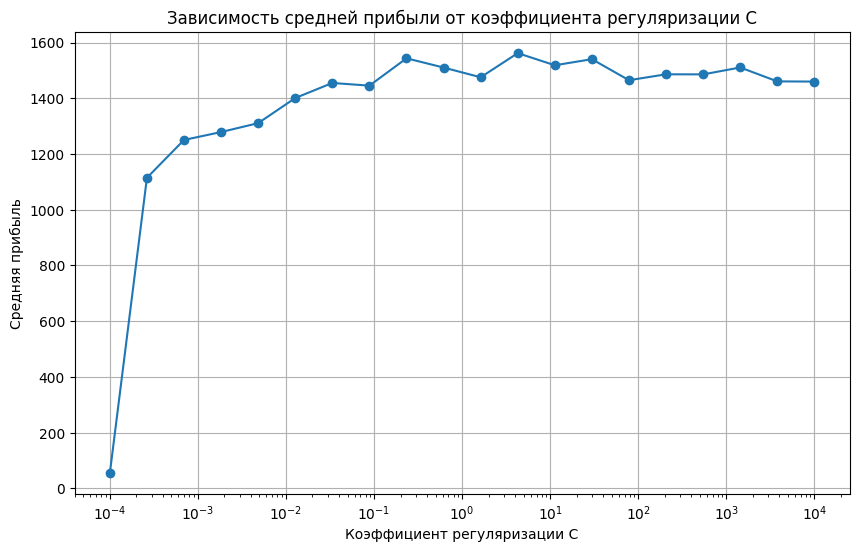

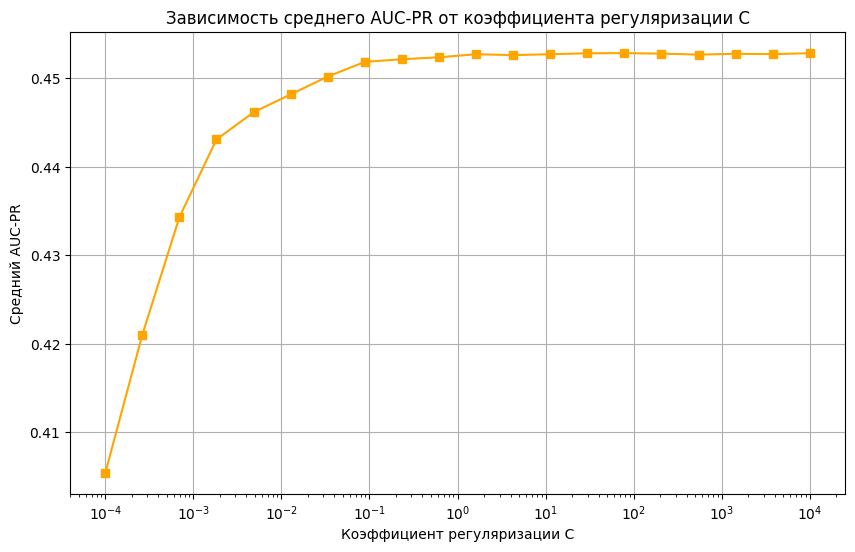

In [93]:
plt.figure(figsize=(10,6))
plt.plot(C_vals, profits, marker='o')
plt.xscale('log')
plt.xlabel('Коэффициент регуляризации C')
plt.ylabel('Средняя прибыль')
plt.title('Зависимость средней прибыли от коэффициента регуляризации C')
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(C_vals, auc_prs, marker='s', color='orange')
plt.xscale('log')
plt.xlabel('Коэффициент регуляризации C')
plt.ylabel('Средний AUC-PR')
plt.title('Зависимость среднего AUC-PR от коэффициента регуляризации C')
plt.grid(True)
plt.show()

При многократных запусках перебора коэффициента регуляризации C мы заметили, что наиболее оптимальные значения всегда были высокими. Это показывает, что слабая регуляризация помогает модели лучше предсказывать прибыль. Таким образом, можно сделать вывод, что для нашей задачи стоит использовать большие значения C, чтобы максимизировать прибыль банка.

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [95]:
# your code here

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ В нашем бизнесе важнее recall, так как мы стремимся максимально охватить тех клиентов, которые действительно заинтересованы в предложении банка открыть депозит. Высокий recall означает, что мы минимизируем количество пропущенных потенциально заинтересованных клиентов, что напрямую влияет на увеличение прибыли банка. Хотя высокий precision также важен для минимизации затрат на неэффективные звонки, приоритет все же отдается recall, чтобы максимизировать общее количество успешных сделок.



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот. Добавьте новую ML-метрику в ваш CV-пайплайн, найдите такой порог, при котором бизнес-метрика максимальна, и проверьте, связана ли новая ML метрика с профитом

In [116]:

def cross_validate_threshold(
    X,
    y,
    thresholds=np.arange(0, 1.01, 0.01),
    n_splits=5,
    random_state=777,
    shuffle=True,
    cost_per_call=2,
    profit_per_yes=10
):
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)
    threshold_profit = {threshold: [] for threshold in thresholds}
    auc_pr_results = {threshold: [] for threshold in thresholds}

    for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
        categorical_features = X.select_dtypes(include=['object']).columns.tolist()

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numeric_features),
                ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
            ]
        )

        X_train_transformed = preprocessor.fit_transform(X_train_fold)
        X_test_transformed = preprocessor.transform(X_test_fold)

        model = LogisticRegression(max_iter=1000, random_state=777)
        model.fit(X_train_transformed, y_train_fold)

        y_pred_prob = model.predict_proba(X_test_transformed)[:, 1]

        for threshold in thresholds:
            y_pred = (y_pred_prob >= threshold).astype(int)
            n_calls = y_pred.sum()
            n_success = ((y_pred == 1) & (y_test_fold == 1)).sum()
            profit = n_success * profit_per_yes - n_calls * cost_per_call

            threshold_profit[threshold].append(profit)
            auc_pr = average_precision_score(y_test_fold, y_pred_prob)
            auc_pr_results[threshold].append(auc_pr)

        print(f"Фолд {fold} завершен.")

    avg_profit = {threshold: np.mean(profits) for threshold, profits in threshold_profit.items()}
    avg_auc_pr = {threshold: np.mean(auc_prs) for threshold, auc_prs in auc_pr_results.items()}

    return avg_profit, avg_auc_pr

avg_profit, avg_auc_pr = cross_validate_threshold(X, y)
profit_df = pd.DataFrame(list(avg_profit.items()), columns=['Threshold', 'Average_Profit'])
auc_pr_df = pd.DataFrame(list(avg_auc_pr.items()), columns=['Threshold', 'Average_AUC_PR'])

results_df = pd.merge(profit_df, auc_pr_df, on='Threshold')
best_threshold = results_df.loc[results_df['Average_Profit'].idxmax(), 'Threshold']
max_profit = results_df['Average_Profit'].max()

print(f"\nНаилучший порог бинаризации: {best_threshold}")
print(f"Максимальная средняя прибыль: ${max_profit:.2f}")


Фолд 1 завершен.
Фолд 2 завершен.
Фолд 3 завершен.
Фолд 4 завершен.
Фолд 5 завершен.

Наилучший порог бинаризации: 0.2
Максимальная средняя прибыль: $2794.40


Постройте график зависимости прибыли от порога бинаризации. Выделите наилучший порог




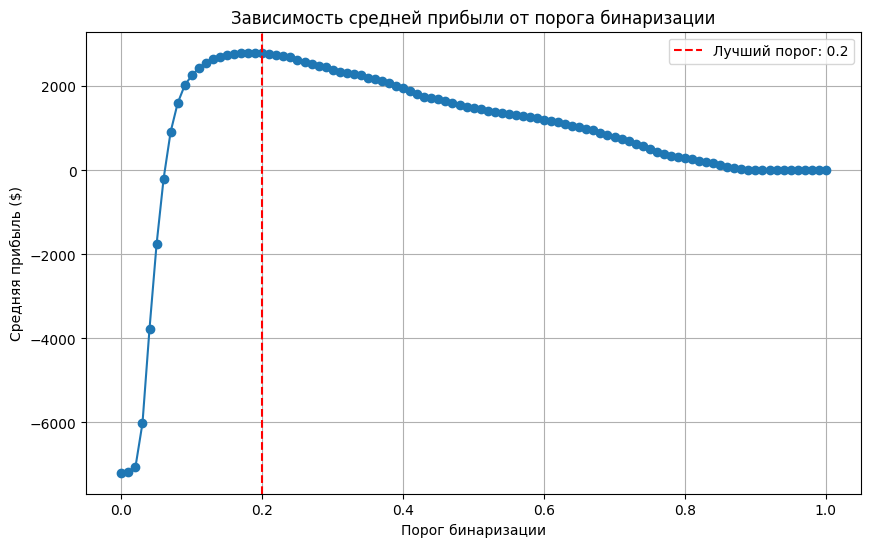

In [117]:
plt.figure(figsize=(10,6))
plt.plot(results_df['Threshold'], results_df['Average_Profit'], marker='o')
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Лучший порог: {best_threshold}')
plt.xlabel('Порог бинаризации')
plt.ylabel('Средняя прибыль ($)')
plt.title('Зависимость средней прибыли от порога бинаризации')
plt.legend()
plt.grid(True)
plt.show()

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ Да, заметна закономерность: наилучшая прибыль достигается при низком пороге бинаризации, около 0.2. Это связано с тем, что низкий порог позволяет модели предсказывать больше положительных случаев (высокий recall), что увеличивает количество успешных звонков клиентов, приносящих прибыль. Несмотря на то, что при таком пороге может увеличиться количество ложноположительных прогнозов, стоимость неудачных звонков ниже прибыли от успешных, что в итоге приводит к общей увеличению прибыли банка. Таким образом, выбор низкого порога оптимизирует баланс между охватом клиентов и затратами на звонки, что соответствует нашей бизнес-стратегии максимизации прибыли.

Наконец, чтобы точнее понять, что наша модель лучше исходной, посчитайте среднее и стандартное отклонение по фолдам бизнес-метрики для оптимизированной модели (гиперпараметры + порог) и дефолтной логистической регрессии. Проверьте, действительно ли удалось добиться значимого изменения прибыли — примените какой-либо статистический тест (например, парный t-критерий с $\alpha=0.95$) к метрике, полученной двумя этими моделями

In [68]:
# your code here

# __Бонусная часть. Многоклассовая классификация__ (1.5 балла)

Как известно, некоторые задачи не ограничиваются всего лишь двумя классами. На лекции вы проходили несколько способов обобщения линейных моделей на этот случай: One-vs-Rest и One-vs-One. Ниже мы посмотрим, в чём преимущества и недостатки обоих подходов, а так же попробуем ещё один чуть более экзотический метод

#### **Задание 14. One-vs-Rest vs One-vs-One** (0.5 балла)

В качестве [датасета](https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data) здесь и ниже мы будем брать очень жизненные и актуальные данные о том, доучится студент или нет, в зависимости от курсов, возраста, гендера и прочих (не)осуждаемых признаков.

In [69]:
import kagglehub

path = kagglehub.dataset_download("thedevastator/higher-education-predictors-of-student-retention") + "/dataset.csv"

features = ["Marital status", "Course", "Nacionality", "Gender", "Age at enrollment"]
target = "Target"

100%|██████████| 87.2k/87.2k [00:00<00:00, 53.1MB/s]

Extracting files...


Будем смотреть только какое-то подмножество наиболее весёлых факторов. От вас по классике потребуется их преобразовать, в зависимости от того, числовые они или категориальные и **закодировать таргет чиселками!!!**

In [70]:
# your code here

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=228, shuffle=True, test_size=0.2)

Ваш следующий шаг - посмотреть, каким образом в `sklearn` реализованы OvR и OvO, обучить таким образом логистическую регрессию с `max_iter=10000`, далее выбрать какую-то метрику (и её усреднение, его выбор тоже аргументируйте), и сравнить следующие параметры:
- число классификаторов
- скорость обучения
- качество модели

Также сохраните куда-нибудь предсказания вероятностей у каждой из моделей. Это можно сделать не одним способом, но возможно вам чуть с этим поможет следующий пункт


In [72]:
# your code here

Как вы объясните полученные результаты?

__Ответ:__ # your code here

#### __Задание 15. Softmax регрессия__ (1 балл)

Однако любознательные машинисты могут задаться вопросом "А зачем нам вся эта шляпа, если у сигмоиды есть обобщение на случай многоклассовой классификации?" Если вам понравилось считать градиенты в прошлом дз, или вам нравится обучать нейросети, этот пункт для вас. Здесь мы попробуем построить одну-единственную модель, которая будет всё предсказывать, а также сравним с вариантами выше

Начнём с подсчёта лосса. Вспомним, что логистическая функция потерь это частный случай кросс-энтропии, её и будем пытаться оптимизировать.

$$
\text{CE}(X, y) = -\frac{1}{N}\sum_i \sum_k [y_i = k] \log p(x_i = k)
$$
Вероятности в данном случае будем считать при помощи софтмакса, что есть общий случай сигмоиды

$$
p(x_i) = \text{Softmax}(a(x_i)); \quad
\text{Softmax}(x)_k = \frac{e^{x_{k}}}{\sum_j e^{x_{j}}} \\
$$

Предсказание модели на одном объекта будет делаться уже при помощи матрицы весов, посклоьку выходов несколько

$$
a(x_i) = x_i\cdot W \\
$$

Ниже предлагается написать код для такой функции потерь. Если необходимо, модифицируйте шаблон по своему усмотрению (вспомогательные функции, новые аргументы, всё, что душа пожелает)

In [73]:
from typing import Iterable, Optional
from torch.nn.functional import cross_entropy
import torch

def custom_ce(
    y_pred: np.ndarray[float],
    y_true: np.ndarray[int],
) -> float:
    # your code here
    return

In [74]:
for _ in range(1000):

    n_objects = np.random.randint(1, 100)
    n_classes = np.random.randint(2, 20)
    y_pred = np.random.normal(0, 1, (n_objects, n_classes))
    y_true = np.random.randint(low=0, high=n_classes, size=(n_objects,))

    your_ce = custom_ce(y_pred, y_true) # не забудьте поправить, если меняли шаблон
    torch_ce = cross_entropy(torch.tensor(y_pred), torch.tensor(y_true))
    assert np.allclose(your_ce, torch_ce), "Что-то пошло не так"

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

Дальше самая интересная часть - нужно вывести производную этой функции потерь (на всякий случай уточним, что `torch` использовать нельзя, разве что для самопроверки). Полезные факты, которые вам могут пригодиться:

- в матричном виде найти производную непросто, попробуйте сперва сделать это для одного объекта, обобщить будет полегче
- логсофтмакс дифференцировать гораздо легче, чем просто софтмакс
- не забывайте про правило дифференцирования сложной функции
- поскольку веса в данном случае матрица, результат будет тоже матрица, учтите при сверке размерностей
- если вы не придумали, как преобразовать индикаторы в векторный вид, сейчас самое время

In [ ]:
def ce_gradient(X: np.ndarray, W: np.ndarray, y: np.ndarray) -> np.ndarray[float]:
    # your code here
    return

Дальше дело за малым. Вспомните (или узнайте), как делается градиентный спуск, и дополните класс софтмакс-регрессии ниже. Здесь разумнее использовать критерий останова по итерациям, но логрег из `sklearn` устроен немного хитрее. Если хотите добавить еще критерии останова, какие-то другие параметры, то пожалуйста

In [ ]:
class SoftmaxRegression:

    def __init__(self, lr=1e-3, max_iter=10000):
        self.W = None
        self.max_iter = max_iter
        self.lr = lr

    def fit(self, X, y):
        # your code here

    def predict(self, X, y=None):
        # your code here

Обучите на тех же данных, что и выше, замерьте те же три параметра, плюс сравните значения кросс-энтропии для уже трёх моделей. Сравните модели между собой и выберите фаворита в данной задаче.

In [ ]:
# your code here

__Ответ__: # your text here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ Манную кашу